In [2]:
import cv2,math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img = cv2.imread('./test.jpg')
h,w,c = img.shape
print h,w,c

1080 1440 3


# 1. BGR to GRAY

(1080, 1440)


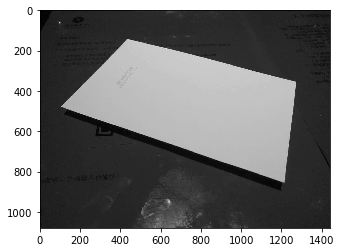

In [4]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print img_gray.shape

#cv2.imwrite('./gray.jpg',img_gray)
plt.imshow(img_gray,cmap='gray')

# 2. Image Binaryzation

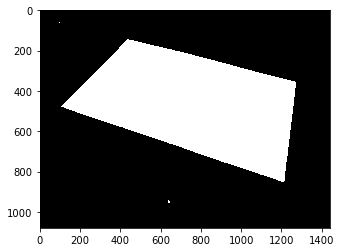

In [5]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(img_gray,150,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap='gray')

# 3. Edge Detection

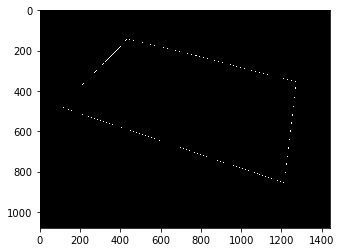

In [6]:
img_edge = cv2.Canny(img_gray,300,600)
#cv2.imwrite('./edge.jpg',img_edge)
plt.imshow(img_edge,cmap='gray')

# 4. Line Detection

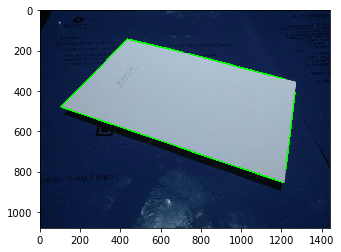

In [7]:
lines = cv2.HoughLinesP(img_edge, 1.0, np.pi/180, 100, minLineLength=0, maxLineGap=50)

tmp = img.copy()
for line in lines:
    [xmin,ymin,xmax,ymax] = line[0]
    cv2.line(tmp,(xmin,ymin),(xmax,ymax),(0,255,0),5)
plt.imshow(tmp)

# 5. Image Rotation

### 5.1 Get the longest line

[429 589 969 774]


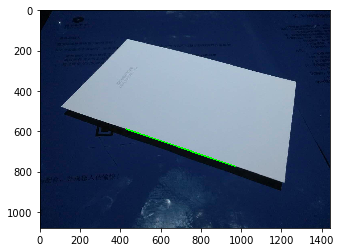

In [8]:
length_list = []
for line in lines:
    [xmin,ymin,xmax,ymax] = line[0]
    #print line
    length = math.sqrt(pow((xmax - xmin),2) + pow((ymax - ymin),2))
    length_list.append((line[0],length))
longest = sorted(length_list, key=lambda item:item[1] ,reverse=True)[0][0]
print longest

[xmin,ymin,xmax,ymax] = longest
tmp = img.copy()
cv2.line(tmp,(xmin,ymin),(xmax,ymax),(0,255,0),5)
plt.imshow(tmp)

### 5.2 Get the rotation angle

In [9]:
angle = math.degrees(math.atan2(longest[3]-longest[1],longest[2]-longest[0]))
print angle

18.9110800746


### 5.3 Padding image

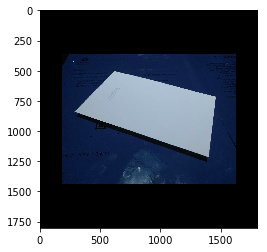

In [10]:
D = int(math.sqrt(pow(w,2) + pow(h,2)))
img_padded = cv2.copyMakeBorder(img, 
                                int((D-h)/2)+1, 
                                int((D-h)/2)+1, 
                                int((D-w)/2)+1, 
                                int((D-w)/2)+1, 
                                cv2.BORDER_CONSTANT, value=(0,0,0))
#cv2.imwrite('./padded.jpg',img_padded)
plt.imshow(img_padded)

### 5.4 Rotate image

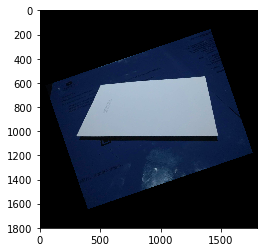

In [11]:
M = cv2.getRotationMatrix2D((D/2,D/2), angle, 1)
img_rotated = cv2.warpAffine(img_padded, M, (D,D))
#cv2.imwrite('./rotated.jpg',img_rotated)
plt.imshow(img_rotated)

# 6. Perspective Transform

### 6.1 Edge Detection

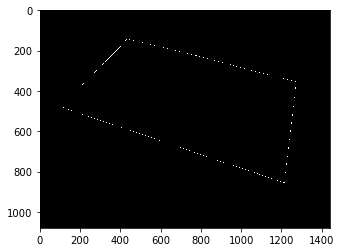

In [12]:
img = cv2.imread('./test.jpg')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_edge = cv2.Canny(img_gray,100,600)
plt.imshow(img_edge,cmap='gray')

### 6.2 Get image outline

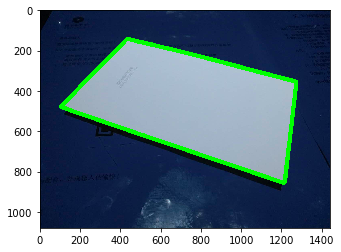

In [13]:
tmp = img_edge.copy()
tmp, contours, hierarchy = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
hull = cv2.convexHull(cnt,returnPoints = False)
defects = cv2.convexityDefects(cnt,hull)

tmp = img.copy()
for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0] # [ start point, end point, farthest point, approximate distance to farthest point ]
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    cv2.line(tmp,start,end,[0,255,0],20)
    #print 's:e',(start,end)
plt.imshow(tmp)

### 6.3 Get points of corners

[(104, 478), (1211, 855), (1272, 357), (433, 143)]


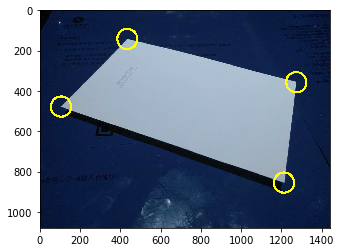

In [14]:
tmp = img_edge.copy()
tmp, contours, hierarchy = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
approx = cv2.approxPolyDP(cnt,10,True)
#print approx
corners = []
tmp = img.copy()
for c in approx:
    cv2.circle(tmp,tuple(c[0]),50,(255,255,0),10)
    corners.append(tuple(c[0]))
plt.imshow(tmp)
print corners

### 6.4 Get output shape

In [15]:
corners = sorted(corners)
#print corners

corner_list = []

if corners[0][1] > corners[1][1]:
    corner_list.append(corners[1])
    corner_list.append(corners[0])
else:
    corner_list.append(corners[0])
    corner_list.append(corners[1])
    
if corners[2][1] > corners[3][1]:
    corner_list.append(corners[3])
    corner_list.append(corners[2])
else:
    corner_list.append(corners[2])
    corner_list.append(corners[3])

print corner_list #[top_left,bottom_left,top_right,bottom,right]

hl = abs(corner_list[1][1] - corner_list[0][1])
wl = abs(corner_list[1][0] - corner_list[0][0])
dl = int(math.sqrt(pow(wl,2) + pow(hl,2)))

hr = abs(corner_list[3][1] - corner_list[2][1])
wr = abs(corner_list[3][0] - corner_list[2][0])
dr = int(math.sqrt(pow(wr,2) + pow(hr,2)))

height = max(dl,dr)

ht = abs(corner_list[2][1] - corner_list[0][1])
wt = abs(corner_list[2][0] - corner_list[0][0])
dt = int(math.sqrt(pow(wt,2) + pow(ht,2)))

hb = abs(corner_list[3][1] - corner_list[1][1])
wb = abs(corner_list[3][0] - corner_list[1][0])
db = int(math.sqrt(pow(wb,2) + pow(hb,2)))

width = max(dt,db)

print 'height',height
print 'width',width

[(433, 143), (104, 478), (1272, 357), (1211, 855)]
height 501
width 1169


### 6.5 Transform image perspectively

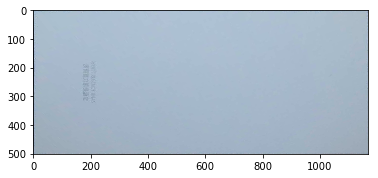

In [16]:
pts1 = np.float32(corner_list)
pts2 = np.float32([[0,0],[0,height],[width,0],[width,height]])

tmp = img.copy()
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(tmp,M,(width,height))
plt.imshow(dst)